In [1]:
import pandas as pd
import numpy as np
from bioreactor.plotting import *
from bioreactor.use_colors import *
from bioreactor.annotation import *
from bioreactor.utils import read_dataset, median_scale
from bioreactor.ssgsea import *
from bioreactor.gsea import *
from bioreactor.expression import  *
from bioreactor.pathway_scoring import *
from bioreactor.survival import * 
from bioreactor.graphs import *

import pickle

from bioreactor.plotting import *
from bioreactor.use_colors import *
from bioreactor.utils import *
from bioreactor.gsea import *
from bioreactor.mutations import *
from bioreactor.ssgsea import *
from bioreactor.clustering import *
from bioreactor.oncoplot2 import *
from bioreactor.cna import *

from typing import Tuple, List, Optional
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Read pancan data

In [3]:
cohorts = [
 'TCGA-BLCA',
 'TCGA-CHOL',
 'TCGA-HNE_SCC',
 'TCGA-KICH',
 'TCGA-LIHC',
 'TCGA-OV',
 'TCGA-PAAD',
 'TCGA-PCPG',
 'TCGA-SKCM',
 'TCGA-THCA',
 'TCGA-ACC',
 'TCGA-BRCA_Basal',
 'TCGA-BRCA_Her2',
 'TCGA-BRCA_LumiNorm',
 'TCGA-COREAD',
 'TCGA-Glioblastoma',
 'TCGA-KIRC',
 'TCGA-KIRP',
 'TCGA-LUAD',
 'TCGA-LUSC',
 'TCGA-MESO',
 'TCGA-PRAD',
 'TCGA-SARC',
 'TCGA-TGCT',
 'TCGA-THYM',
 'TCGA-UCEC',
 'TCGA-UCS',
 'TCGA-UVM']

In [4]:
c = os.listdir('/uftp2/Datasets/Xena/TCGA/TCGA_Kallisto_genes_est_counts_without_noncoding/')
cohorts_with_counts = [i for i in c if 'Kallisto' in i]
cohorts_with_counts

['CHOL_Kallisto-Xena_genes_est_counts_without_noncoding.tsv.gz',
 'PAAD_Kallisto-Xena_genes_est_counts_without_noncoding.tsv.gz',
 'UVM_Kallisto-Xena_genes_est_counts_without_noncoding.tsv.gz',
 'THYM_Kallisto-Xena_genes_est_counts_without_noncoding.tsv.gz',
 'DLBC_Kallisto-Xena_genes_est_counts_without_noncoding.tsv.gz',
 'ACC_Kallisto-Xena_genes_est_counts_without_noncoding.tsv.gz',
 'STAD_Kallisto-Xena_genes_est_counts_without_noncoding.tsv.gz',
 'ESCA_Kallisto-Xena_genes_est_counts_without_noncoding.tsv.gz',
 'CESC_Kallisto-Xena_genes_est_counts_without_noncoding.tsv.gz',
 'COAD_Kallisto-Xena_genes_est_counts_without_noncoding.tsv.gz',
 'MESO_Kallisto-Xena_genes_est_counts_without_noncoding.tsv.gz',
 'KIRP_Kallisto-Xena_genes_est_counts_without_noncoding.tsv.gz',
 'THCA_Kallisto-Xena_genes_est_counts_without_noncoding.tsv.gz',
 'PCPG_Kallisto-Xena_genes_est_counts_without_noncoding.tsv.gz',
 'SKCM_Kallisto-Xena_genes_est_counts_without_noncoding.tsv.gz',
 'HNSC_Kallisto-Xena_genes_

In [5]:
tcga_expressions = {}
tcga_counts = {}


for cohort in tqdm(cohorts):
    e = np.log2(read_dataset(f'/uftp2/Datasets/TCGA/current_version/data/recombined_cohorts/{cohort}/expressions.tsv.gz')+1)
    tcga_expressions[cohort] = e

    
for cohort in tqdm(cohorts_with_counts):
    tcga_counts[cohort] = read_dataset(f'/uftp2/Datasets/Xena/TCGA/TCGA_Kallisto_genes_est_counts_without_noncoding/{cohort}')

100%|██████████| 33/33 [00:38<00:00,  1.16s/it]


In [6]:
tcga_anno = read_dataset('/uftp2/Datasets/TCGA/current_version/data/annotation.tsv')
tcga_expressions = pd.concat(tcga_expressions.values(), axis=1)
tcga_counts = pd.concat(tcga_counts.values(), axis=1)

# Noise functions

In [131]:
import random
random.seed(42)
np.random.seed(42)

In [132]:
from pathlib import Path
def calculate_sample_noise(
        sample: Union[pd.Series, pd.DataFrame],
        readcounts: Union[float, pd.Series],
        gene_lengths_path=Path('/uftp/gene_data_common/' 'gene_length_values.tsv'),
        alpha=2.05,) -> Union[pd.Series, pd.DataFrame]:
    """
    Calculation of sigma describing gene expression noise in technical replicates.
    For more info, check out https://bostongene.atlassian.net/wiki/spaces/IP/pages/3930259462/Expression+noise
    :param sample: pandas dataframe with expressions in TPM with samples as indexes
    :param readcounts: sample readcounts (sum for every patient) in mln
    :param gene_lengths_path: gene lehgths in bp
    :returns: sigma describing gene expression noise in technical replicates
    """
    gene_length = read_dataset(gene_lengths_path)
    # gene lengths are to be turned to kbp
    gene_length = gene_length / 1000
    noise_sigma = alpha * np.sqrt(sample.T.divide(gene_length.loc[sample.columns, 'length'], axis='index')
                                  / readcounts).T
    return noise_sigma

In [133]:
def generate_noise(sample: pd.Series, noise_sigma: pd.Series) -> pd.Series:
    """
    Method adds Poisson noise (very close approximation) and uniform noise for expressions in TPM.
    For more info, check out https://bostongene.atlassian.net/wiki/spaces/IP/pages/3930259462/Expression+noise
    Uniform noise - proportional to gene expressions noise from a normal distribution.
    :param sample: pandas series with expressions in TPM
    :param noise_sigma: sigma describing gene expression noise in technical replicates from calculate_sample_noise
    :returns: dataframe data with added noise
    """
    return (sample + noise_sigma * np.random.normal(size=sample.shape)).clip(lower=0)

# Calculate noise

In [134]:
tcga_expressions_for_noise, tcga_counts_for_noise = to_common_samples([tcga_expressions.T, tcga_counts.T])

In [135]:
tcga_counts_for_noise = tcga_counts_for_noise.sum(axis=1)
tcga_expressions_for_noise = 2**tcga_expressions_for_noise - 1

In [136]:
noise_sigma = calculate_sample_noise(tcga_expressions_for_noise, tcga_counts_for_noise/1000000)

In [137]:
noise_sigma.head()

Gene,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
TCGA-2J-AAB6-01,0.000000,0.079082,1.807592,0.960398,0.073900,1.519194,0.096703,1.413005,0.612205,0.192912,...,1.075620,0.117495,0.241166,0.509184,0.047147,0.311465,4.790697,0.235851,0.488977,0.488093
TCGA-75-5147-01,0.028772,0.034298,1.974117,0.063355,0.060401,0.579451,0.068911,0.898677,0.436719,0.923082,...,1.266099,0.154194,0.216256,0.428469,0.159065,0.215537,1.692362,0.111645,0.551607,0.320781
TCGA-UZ-A9PS-01,0.000000,0.022511,0.854780,0.095771,0.083712,1.304994,0.157597,1.214752,0.939731,0.000000,...,0.815498,0.209186,0.243137,0.569168,0.065229,0.404842,2.420952,0.330019,0.584438,0.501123
TCGA-LL-A740-01,0.000000,0.007747,1.964252,0.117723,0.000000,0.744960,0.061659,1.027764,3.425064,0.127813,...,1.354982,0.154031,0.277776,0.404381,0.210919,0.372019,4.074115,0.256422,0.555574,0.312134
TCGA-EE-A180-06,0.000000,0.011571,1.595702,0.050811,0.066474,0.206957,0.070409,1.355139,0.451437,0.073897,...,1.397320,0.154676,0.209981,0.485889,0.041791,0.291351,2.558389,0.290971,0.550317,0.303176


In [138]:
noise_sigma.replace([np.inf, -np.inf], 0, inplace=True)

# Get noisy genes from TCGA

noisy = half of tcga patients have gene expr - 3*sigma noise < 0

In [139]:
noisy_genes = tcga_expressions_for_noise.columns[(tcga_expressions_for_noise - 3*noise_sigma).median() < 0]

In [140]:
noisy_genes

Index(['A1CF', 'A3GALT2', 'A4GNT', 'AANAT', 'ABCB5', 'ABCC11', 'ABCG4',
       'ABCG8', 'ABHD1', 'ABRA',
       ...
       'ZNF878', 'ZP1', 'ZP2', 'ZPBP2', 'ZPLD1', 'ZSCAN10', 'ZSCAN23',
       'ZSCAN4', 'ZSCAN5B', 'ZSCAN5CP'],
      dtype='object', name='Gene', length=2329)

# Display noisy and non-noisy (both high- and low-expressed) genes

In [16]:
# tcga

In [17]:
sns.set_style('white')

IL4


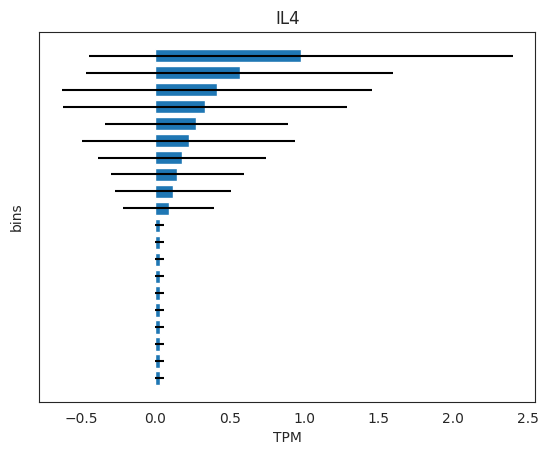

IL5


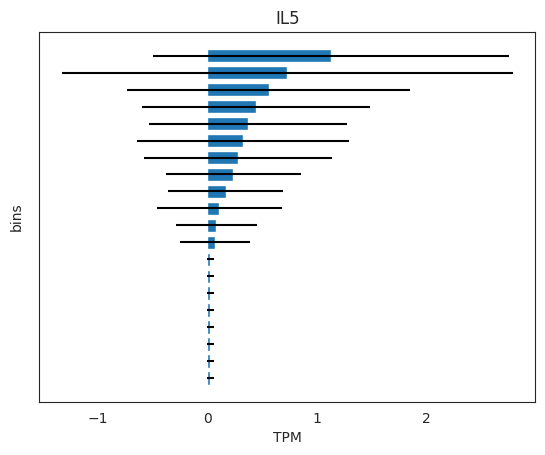

IL10


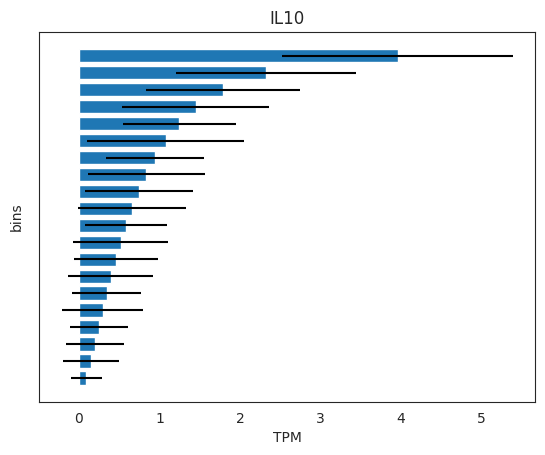

IL11


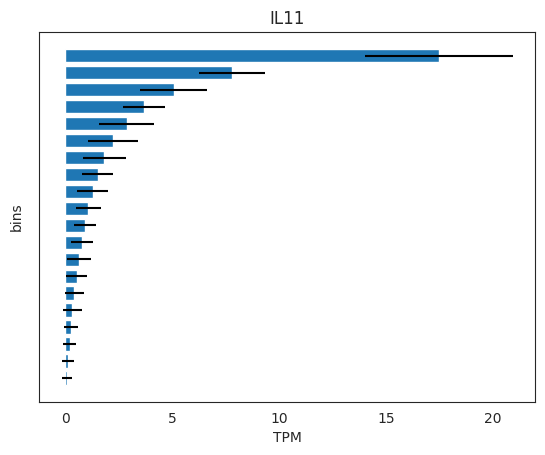

IL13


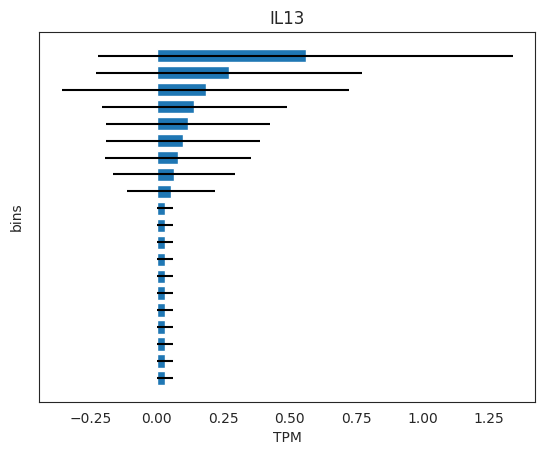

CCL8


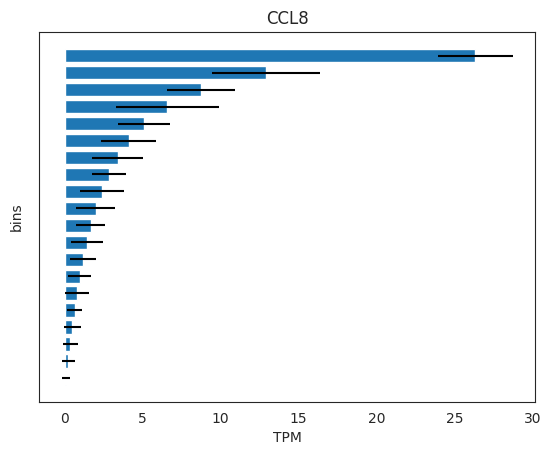

TSLP


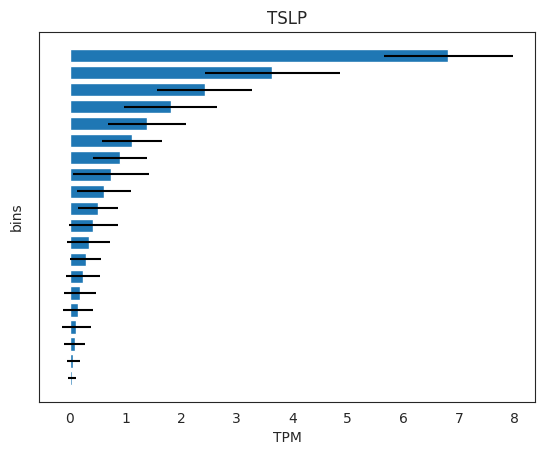

CCL13


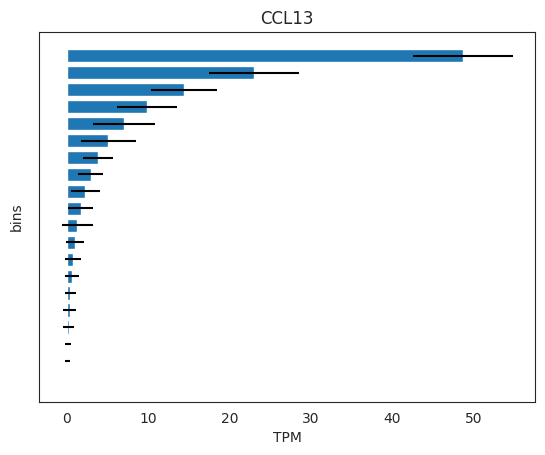

In [18]:
for gene in ['IL4', 'IL5', 'IL10', 'IL11', 'IL13', 'CCL8', 'TSLP', 'CCL13']:
    print(gene)
#idx = tcga_expressions_for_noise[gene][tcga_expressions_for_noise[gene] < 10].index
    expr_bins = pd.cut(tcga_expressions_for_noise[gene].rank(method='first'), 20)
    medians = tcga_expressions_for_noise[gene].groupby(expr_bins).apply(lambda x: np.percentile(x,50,interpolation='nearest'))
    patients = [tcga_expressions_for_noise[gene][tcga_expressions_for_noise[gene] == i].index[0] for i in medians]
    expr_for_plot = [tcga_expressions_for_noise[gene].loc[i] + 0.03 for i in patients]
    std_for_plot = [3*noise_sigma[gene].loc[i] + 0.03 for i in patients]
    plt.barh(range(20), expr_for_plot, xerr=std_for_plot)
    plt.xlabel('TPM')
    plt.ylabel('bins')
    plt.yticks(range(5), [])
    plt.title(gene)
    #plt.grid(b=None)
    #plt.savefig(f"/home/eocheredko/Chess_projects/Signature_validation_paper/Figures/{gene}_noise_bins.svg", format="svg")
    plt.show()

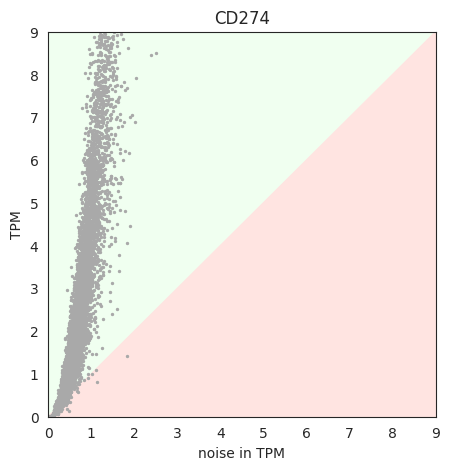

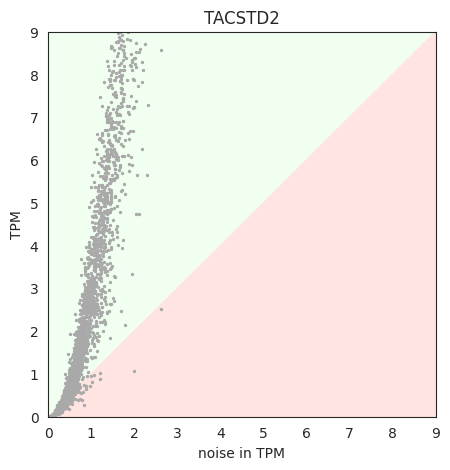

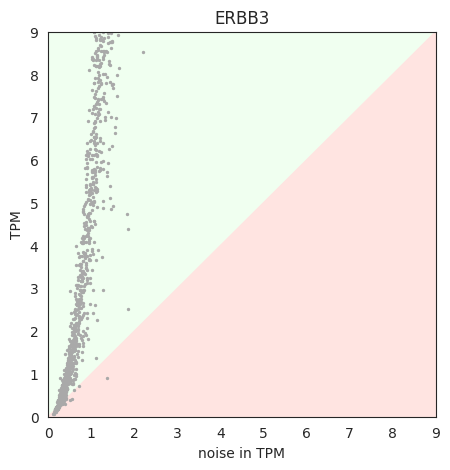

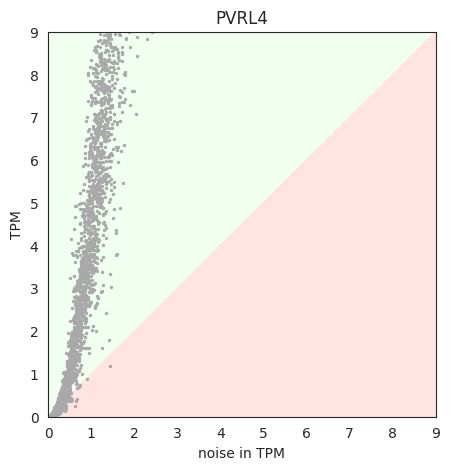

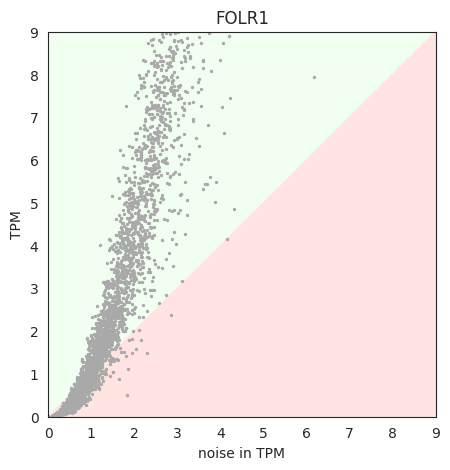

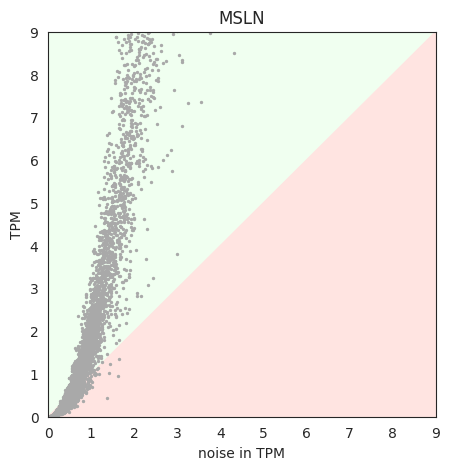

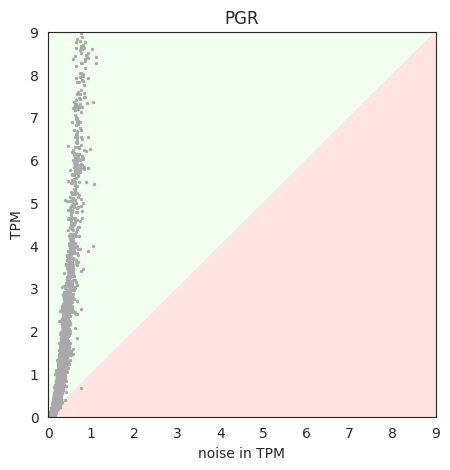

In [28]:
for gene in ['CD274', 'TACSTD2', 'ERBB3', 'PVRL4', 'FOLR1', 'MSLN', 'PGR']:
    
    zscore = (tcga_expressions_for_noise[gene] - tcga_expressions_for_noise[gene].mean())/tcga_expressions_for_noise[gene].std()
    p = zscore[np.abs(zscore) < 3].index
    
    plt.figure(figsize = (5, 5))
    #plt.plot([0, tcga_expressions_for_noise[gene].reindex(p).max()], [0, tcga_expressions_for_noise[gene].reindex(p).max()])
    
    ax=plt.axes()
    ax.set_facecolor('honeydew')
    
    plt.ylabel('TPM')
    plt.xlabel('noise in TPM')
    #plt.grid(b=None)
    plt.fill_between([0, tcga_expressions_for_noise[gene].reindex(p).max()], 
                     [0, tcga_expressions_for_noise[gene].reindex(p).max()],color="mistyrose")
    
    plt.scatter(3*noise_sigma[gene].reindex(p), tcga_expressions_for_noise[gene].reindex(p), s=2, 
               c = 'darkgrey')
    plt.title(gene)
    #plt.xlim(0, tcga_expressions_for_noise[gene].reindex(p).max())
    #plt.ylim(0, tcga_expressions_for_noise[gene].reindex(p).max())
    plt.xlim(0, 9)
    plt.ylim(0, 9)
    
    #plt.savefig(f"/home/eocheredko/Chess_projects/Signature_validation_paper/Figures/{gene}_noise_vs_tpm.svg", format="svg")
    plt.show()

IL5


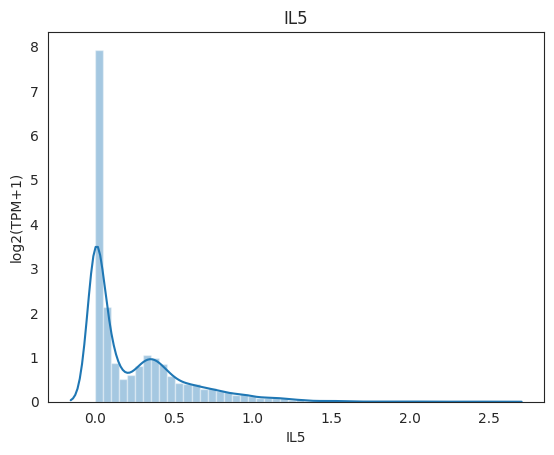

IL10


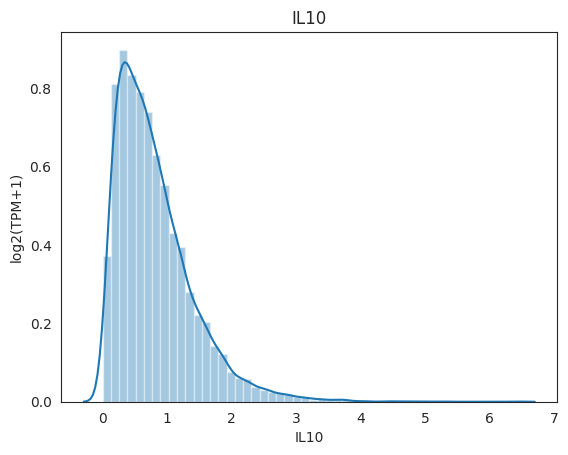

CD8A


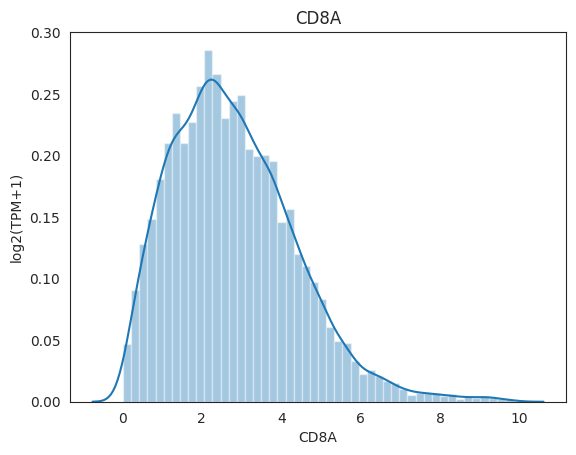

In [20]:
for gene in ['IL5', 'IL10', 'CD8A']:
    print(gene)
    sns.distplot(np.log2(tcga_expressions_for_noise[gene] + 1))
    plt.ylabel('log2(TPM+1)')
    plt.title(gene)
    plt.show()

# TPM vs rank**1/4

In [141]:
ranks = tcga_expressions_for_noise.T['TCGA-XE-A8H4-01'].rank(method='max').sort_values(ascending=False)
ranks_a = pd.Series(ranks.values**0.25, index=ranks.index)

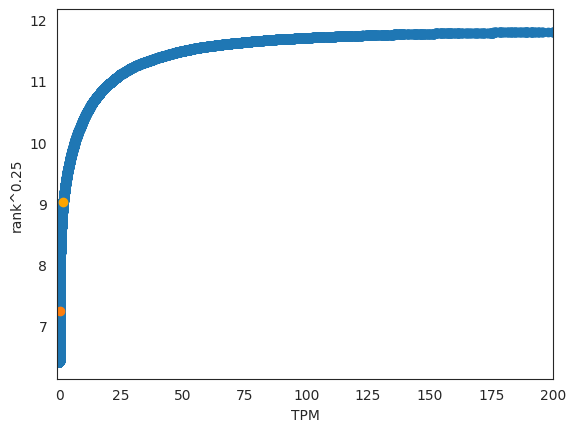

In [142]:
plt.scatter(tcga_expressions_for_noise.T['TCGA-XE-A8H4-01'].reindex(ranks.index), ranks_a)

plt.scatter(tcga_expressions_for_noise.T['TCGA-XE-A8H4-01'].loc['IL5'], ranks_a.loc['IL5'])
plt.scatter(tcga_expressions_for_noise.T['TCGA-XE-A8H4-01'].loc['ITGA1'], ranks_a.loc['ITGA1'], 
           color='orange')

noise_max = tcga_expressions_for_noise.T['TCGA-XE-A8H4-01'].loc['IL5'] + 3*noise_sigma.T['TCGA-XE-A8H4-01'].loc['IL15']

#noise_max_gene_rank = np.abs(tcga_expressions_for_noise.T['TCGA-XE-A8H4-01'] - noise_min).sort_values().index[0]
#plt.scatter(noise_min, ranks_a.loc[noise_max_gene_rank], color='orange')


plt.xlabel('TPM')
plt.ylabel('rank^0.25')
plt.xlim(-1, 200)
#plt.savefig('/home/eocheredko/TPM_vs_ranks.svg', format="svg")
plt.show()

## Noisy genes vs ssgsea score STD

In [267]:
import statsmodels.api as sm

In [167]:
annot_reprod_ldt = read_dataset('/uftp/projects/samples_with_replicates/data/ann.tsv')

In [143]:
expr_reprod_ldt = read_dataset('/uftp/projects/samples_with_replicates/data/exp.tsv')

In [144]:
expr_reprod_ldt = expr_reprod_ldt.T

In [145]:
expr_reprod_ldt = 2**expr_reprod_ldt - 1

In [146]:
med_high_expressed_genes = list(tcga_expressions_for_noise.max()[tcga_expressions_for_noise.min() >= 75].index)
signature = random.sample(med_high_expressed_genes, 100)

In [147]:
noisy_genes = list(noisy_genes)

In [166]:
p = tcga_anno[(tcga_anno.TCGA_unique_cases==1)&(tcga_anno['Diagnosis.acronym']!='Normal')].index
low_expressed_genes = tcga_expressions_for_noise.max()[(tcga_expressions_for_noise.reindex(p).median() <= 10) & 
                                                (tcga_expressions_for_noise.reindex(p).median() >= 0.5)]
low_expressed_genes = list(set(low_expressed_genes.index).difference(set(noisy_genes)))

### Noisy genes

In [156]:
annot_reprod_ldt[annot_reprod_ldt.Group == 'RetroInterM'].Case.unique()

array(['RS0004', 'RS0005', 'RS0007', 'RS0008', 'RS0013', 'RS0028',
       'RS0029', 'RS0037', 'RS0038', 'RS0040'], dtype=object)

In [83]:
(pd.crosstab(annot_reprod_ldt.Group,annot_reprod_ldt.Case).T!=0).astype(int).sum()

Group
RetroInterL    22
RetroInterM    10
ValidIntra      5
dtype: int64

In [241]:
perc_of_noisy_genes = []
ssgsea_scores_std = {}

norm_genes = (random.sample(signature, 100))
norm_genes = expr_reprod_ldt.mean().reindex(norm_genes).sort_values()

for i in tqdm(range(99)):
    stds = {}
    norm_genes = norm_genes[1:]
    for j in range(10):
        current_signature = random.sample(noisy_genes, i) + norm_genes.index.tolist()
        s = {'s': GeneSet('s', '', current_signature)}
        ssgsea_score = ssgsea_formula(expr_reprod_ldt.T, gmt_genes_alt_names(s, 
                                                                             expr_reprod_ldt.columns, 
                                                                             verbose=False))
        stds[j] =  ssgsea_score
    stds = pd.concat(stds)
    perc_of_noisy_genes.append(i)
    ssgsea_scores_std[i] = stds.mean()

100%|██████████| 99/99 [04:06<00:00,  2.49s/it]


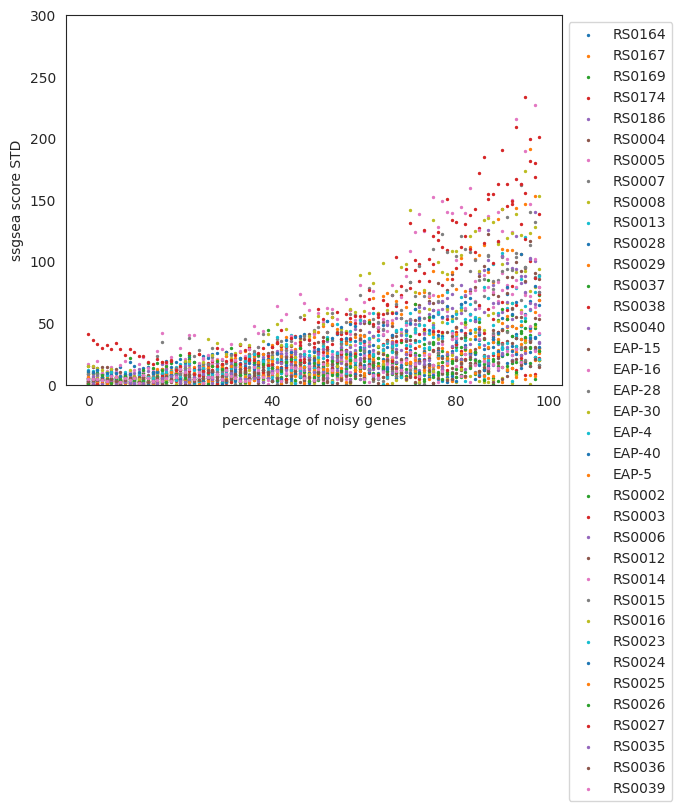

In [94]:
plt.subplots()
for g in annot_reprod_ldt.Case.unique():
    p = annot_reprod_ldt[annot_reprod_ldt.Case == g].index.tolist()
    std = [i[p].std() for i in ssgsea_scores_std.values()]
    plt.scatter(perc_of_noisy_genes, std, label=g, s=2)
    # plt.grid(b=None)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0, 300)
plt.xlabel('percentage of noisy genes')
plt.ylabel('ssgsea score STD')
# plt.grid(b=None)
#plt.savefig(f"/home/eocheredko/Chess_projects/Signature_validation_paper/Figures/noisy_genes_replacement.svg", format="svg")
plt.show()

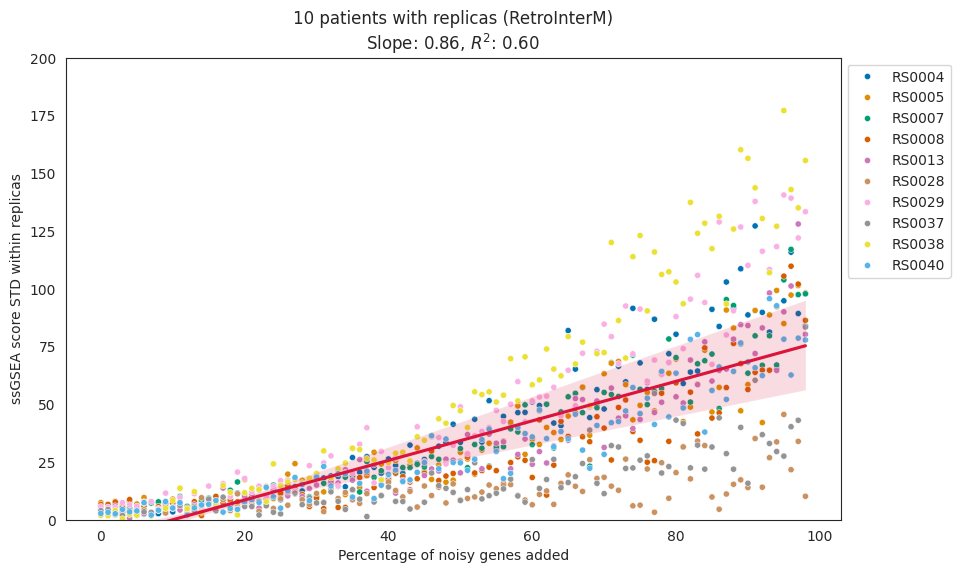

In [268]:
mask = annot_reprod_ldt.Group == 'RetroInterM'
stds = []
cases = []
percentages = []
for g in annot_reprod_ldt[mask].Case.unique():
    p = annot_reprod_ldt[annot_reprod_ldt.Case == g].index.tolist()
    for n,i in ssgsea_scores_std.items():
        stds.append(i[p].std())
        cases.append(g)
        percentages.append(n)

regression_data = pd.DataFrame({
    'percentage': percentages,
    'ssgsea_score_STD': stds,
    'Case': cases
})
regression_data_10_noisy = regression_data
regression_data_10_noisy.to_csv('noise_gene_data_10_noisy.tsv',sep='\t')

# Линейная регрессия
X = sm.add_constant(regression_data['percentage'].astype(float))
y = regression_data['ssgsea_score_STD'].astype(float)
model = sm.OLS(y, X).fit()
slope = model.params[1]
r_squared = model.rsquared


plt.figure(figsize=(10, 6))
sns.scatterplot(data=regression_data, x='percentage', y='ssgsea_score_STD', hue='Case', s=20, palette='colorblind')
sns.regplot(data=regression_data, x='percentage', y='ssgsea_score_STD', scatter=False, color='crimson',ci=95, seed=42,  units='Case')

plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0, 200)
plt.xlabel('Percentage of noisy genes added')
plt.ylabel('ssGSEA score STD within replicas')
plt.title(f'10 patients with replicas (RetroInterM)\nSlope: {slope:.2f}, $R^2$: {r_squared:.2f}')
plt.show()

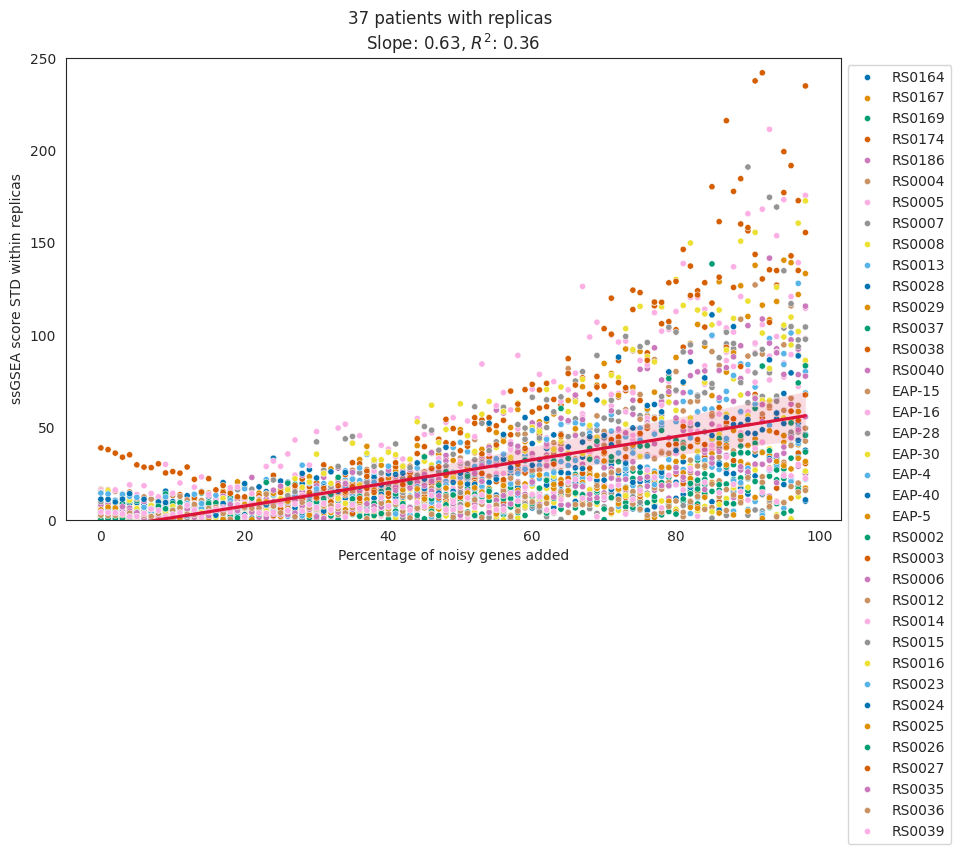

In [277]:
mask = ~annot_reprod_ldt.Group.isna()
stds = []
cases = []
percentages = []
for g in annot_reprod_ldt[mask].Case.unique():
    p = annot_reprod_ldt[annot_reprod_ldt.Case == g].index.tolist()
    for n,i in ssgsea_scores_std.items():
        stds.append(i[p].std())
        cases.append(g)
        percentages.append(n)

regression_data = pd.DataFrame({
    'percentage': percentages,
    'ssgsea_score_STD': stds,
    'Case': cases
})
regression_data_37_noisy = regression_data
regression_data_37_noisy.to_csv('noise_gene_data_37_noisy.tsv',sep='\t')


# Линейная регрессия
X = sm.add_constant(regression_data['percentage'].astype(float))
y = regression_data['ssgsea_score_STD'].astype(float)
model = sm.OLS(y, X).fit()
slope = model.params[1]
r_squared = model.rsquared


plt.figure(figsize=(10, 6))
sns.scatterplot(data=regression_data, x='percentage', y='ssgsea_score_STD', hue='Case', s=20, palette='colorblind')
sns.regplot(data=regression_data, x='percentage', y='ssgsea_score_STD', scatter=False, color='crimson',ci=95, seed=42,  units='Case')

plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0, 250)
plt.xlabel('Percentage of noisy genes added')
plt.ylabel('ssGSEA score STD within replicas')
plt.title(f'37 patients with replicas \nSlope: {slope:.2f}, $R^2$: {r_squared:.2f}')

plt.show()

### Highly expressed genes

In [244]:
perc_of_mh_genes = []
ssgsea_scores_std_mh = {}

norm_genes = (random.sample(signature, 100))
norm_genes = expr_reprod_ldt.mean().reindex(norm_genes).sort_values()

for i in tqdm(range(99)):
    stds = {}
    norm_genes = norm_genes[1:]
    for j in range(10):
        current_signature = random.sample(med_high_expressed_genes, i) + norm_genes.index.tolist()
        s = {'s': GeneSet('s', '', current_signature)}
        ssgsea_score = ssgsea_formula(expr_reprod_ldt.T, gmt_genes_alt_names(s, 
                                                              expr_reprod_ldt.columns, verbose=False))
        stds[j] =  ssgsea_score
    stds = pd.concat(stds)
    perc_of_mh_genes.append(i)
    ssgsea_scores_std_mh[i] = stds.mean()

100%|██████████| 99/99 [04:06<00:00,  2.49s/it]


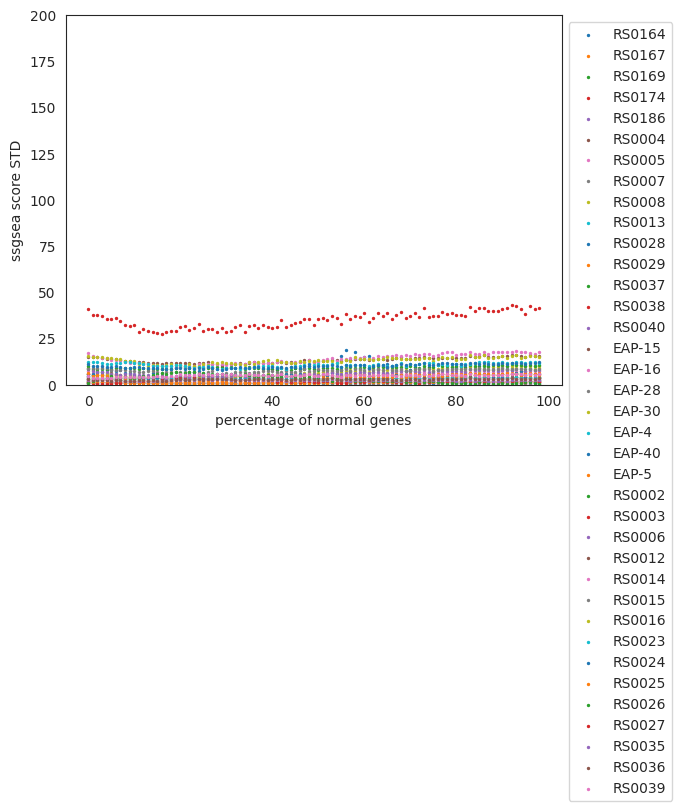

In [96]:
plt.subplots()
for g in annot_reprod_ldt.Case.unique():
    p = annot_reprod_ldt[annot_reprod_ldt.Case == g].index.tolist()
    std = [i[p].std() for i in ssgsea_scores_std_mh.values()]
    plt.scatter(perc_of_mh_genes, std, label=g, s=2)
    # plt.grid(b=None)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0, 200)
plt.xlabel('percentage of normal genes')
plt.ylabel('ssgsea score STD')
# plt.grid(b=None)
#plt.savefig(f"/home/eocheredko/Chess_projects/Signature_validation_paper/Figures/norm_genes_replacement.svg", format="svg")
plt.show()

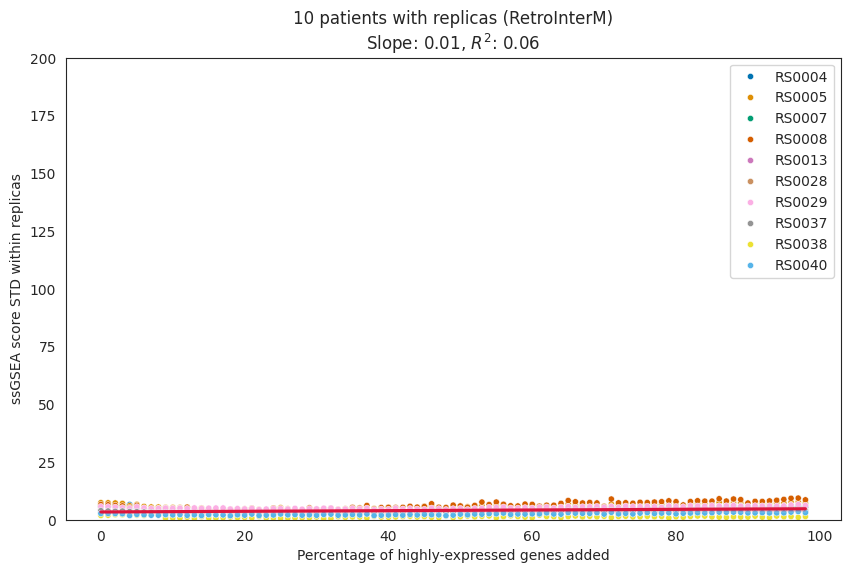

In [271]:
mask = annot_reprod_ldt.Group == 'RetroInterM'
stds = []
cases = []
percentages = []
for g in annot_reprod_ldt[mask].Case.unique():
    p = annot_reprod_ldt[annot_reprod_ldt.Case == g].index.tolist()
    for n,i in ssgsea_scores_std_mh.items():
        stds.append(i[p].std())
        cases.append(g)
        percentages.append(n)

regression_data = pd.DataFrame({
    'percentage': percentages,
    'ssgsea_score_STD': stds,
    'Case': cases
})


# Линейная регрессия
X = sm.add_constant(regression_data['percentage'].astype(float))
y = regression_data['ssgsea_score_STD'].astype(float)
model = sm.OLS(y, X).fit()
slope = model.params[1]
r_squared = model.rsquared

regression_data_10_highly = regression_data
regression_data_10_highly.to_csv('noise_gene_data_10_highly.tsv',sep='\t')
plt.figure(figsize=(10, 6))
sns.scatterplot(data=regression_data, x='percentage', y='ssgsea_score_STD', hue='Case', s=20, palette='colorblind')
sns.regplot(data=regression_data, x='percentage', y='ssgsea_score_STD', scatter=False, color='crimson',ci=95, seed=42,  units='Case')

plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0, 200)
plt.xlabel('Percentage of highly-expressed genes added')
plt.ylabel('ssGSEA score STD within replicas')
plt.title(f'10 patients with replicas (RetroInterM)\nSlope: {slope:.2f}, $R^2$: {r_squared:.2f}')

plt.show()

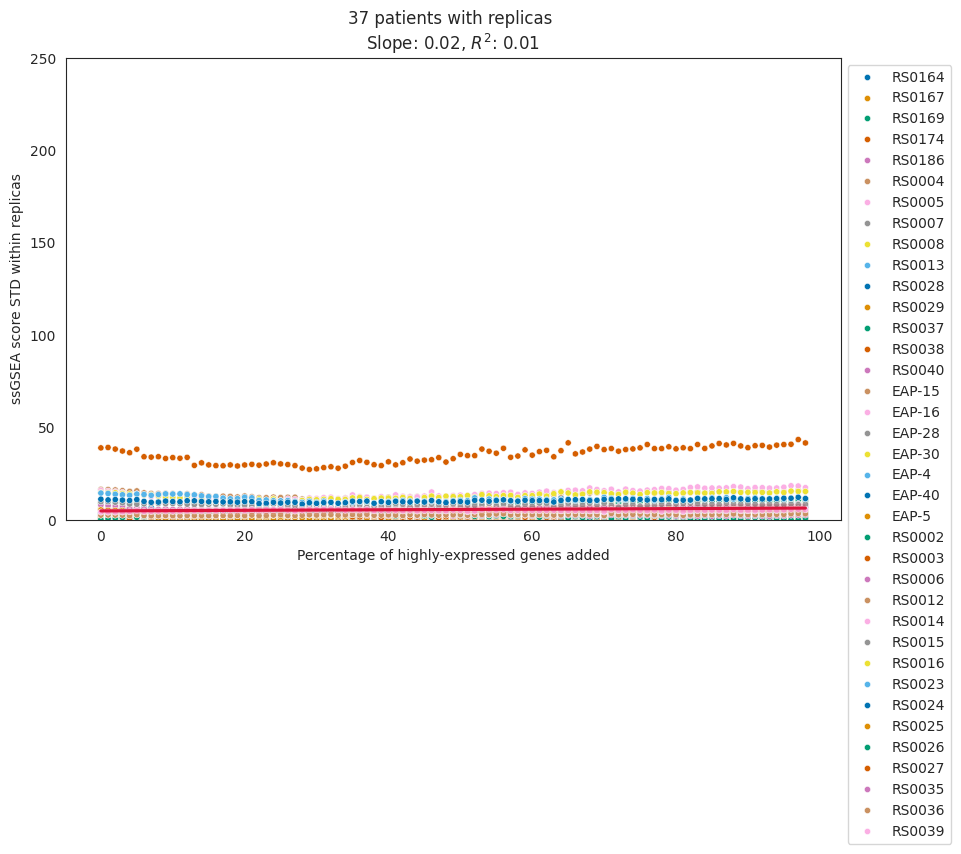

In [276]:
mask = ~annot_reprod_ldt.Group.isna()
stds = []
cases = []
percentages = []
for g in annot_reprod_ldt[mask].Case.unique():
    p = annot_reprod_ldt[annot_reprod_ldt.Case == g].index.tolist()
    for n,i in ssgsea_scores_std_mh.items():
        stds.append(i[p].std())
        cases.append(g)
        percentages.append(n)

regression_data = pd.DataFrame({
    'percentage': percentages,
    'ssgsea_score_STD': stds,
    'Case': cases
})


# Линейная регрессия
X = sm.add_constant(regression_data['percentage'].astype(float))
y = regression_data['ssgsea_score_STD'].astype(float)
model = sm.OLS(y, X).fit()
slope = model.params[1]
r_squared = model.rsquared

regression_data_37_highly = regression_data
regression_data_37_highly.to_csv('noise_gene_data_37_highly.tsv',sep='\t')
plt.figure(figsize=(10, 6))
sns.scatterplot(data=regression_data, x='percentage', y='ssgsea_score_STD', hue='Case', s=20, palette='colorblind')
sns.regplot(data=regression_data, x='percentage', y='ssgsea_score_STD', scatter=False, color='crimson',ci=95, seed=42,  units='Case')

plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0, 250)
plt.xlabel('Percentage of highly-expressed genes added')
plt.ylabel('ssGSEA score STD within replicas')
plt.title(f'37 patients with replicas \nSlope: {slope:.2f}, $R^2$: {r_squared:.2f}')

plt.show()

In [263]:
regression_data_37_highly.groupby('Case').mean().ssgsea_score_STD.sort_values(ascending=False)[:5]

Case
RS0027    35.078627
RS0014    14.217661
RS0012    13.811502
RS0016    13.029247
RS0023    11.349684
Name: ssgsea_score_STD, dtype: float64

### Low expressed genes

In [168]:
perc_of_low_genes = []
ssgsea_scores_std_low = {}

norm_genes = (random.sample(signature, 100))
norm_genes = expr_reprod_ldt.mean().reindex(norm_genes).sort_values()

for i in tqdm(range(99)):
    stds = {}
    norm_genes = norm_genes[1:]
    for j in range(10):
        current_signature = random.sample(low_expressed_genes, i) + norm_genes.index.tolist()
        s = {'s': GeneSet('s', '', current_signature)}
        ssgsea_score = ssgsea_formula(expr_reprod_ldt.T, gmt_genes_alt_names(s, 
                                                              expr_reprod_ldt.columns, verbose=False))
        stds[j] =  ssgsea_score
    stds = pd.concat(stds)
    perc_of_low_genes.append(i)
    ssgsea_scores_std_low[i] = stds.mean()

100%|██████████| 99/99 [03:50<00:00,  2.33s/it]


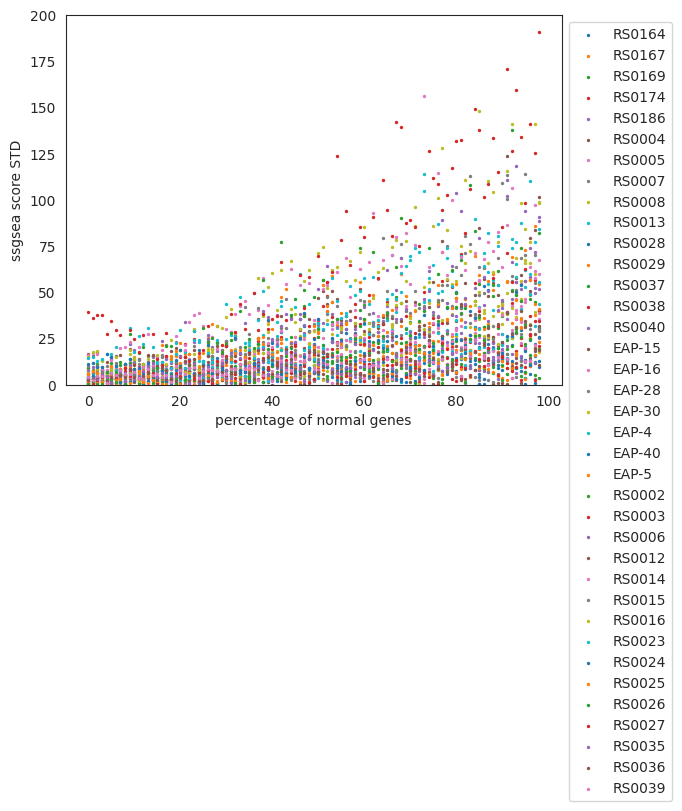

In [169]:
plt.subplots()
for g in annot_reprod_ldt.Case.unique():
    p = annot_reprod_ldt[annot_reprod_ldt.Case == g].index.tolist()
    std = [i[p].std() for i in ssgsea_scores_std_low.values()]
    plt.scatter(perc_of_low_genes, std, label=g, s=2)
    # plt.grid(b=None)
plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0, 200)
plt.xlabel('percentage of normal genes')
plt.ylabel('ssgsea score STD')
# plt.grid(b=None)
#plt.savefig(f"/home/eocheredko/Chess_projects/Signature_validation_paper/Figures/low_genes_replacement.svg", format="svg")
plt.show()

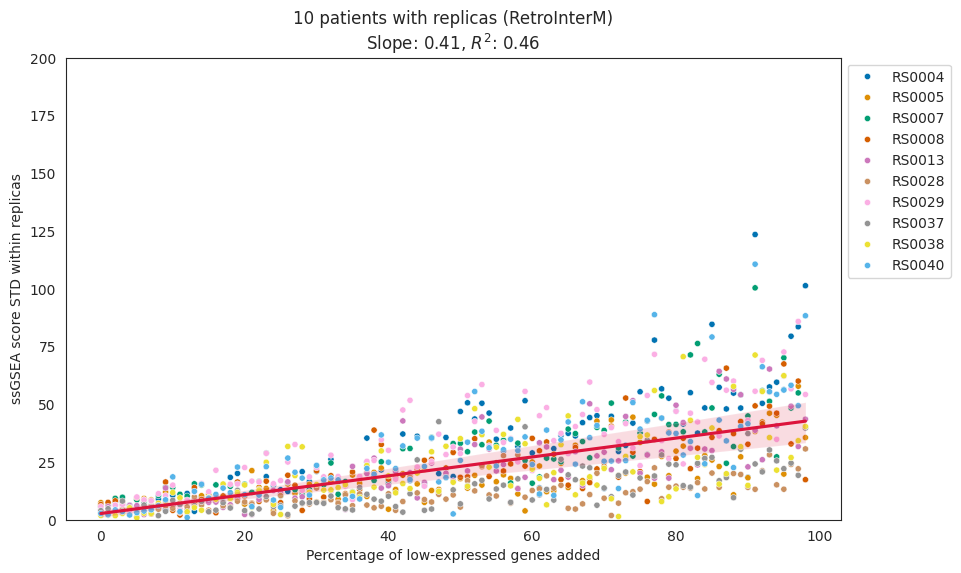

In [273]:
mask = annot_reprod_ldt.Group == 'RetroInterM'
stds = []
cases = []
percentages = []
for g in annot_reprod_ldt[mask].Case.unique():
    p = annot_reprod_ldt[annot_reprod_ldt.Case == g].index.tolist()
    for n,i in ssgsea_scores_std_low.items():
        stds.append(i[p].std())
        cases.append(g)
        percentages.append(n)

regression_data = pd.DataFrame({
    'percentage': percentages,
    'ssgsea_score_STD': stds,
    'Case': cases
})


# Линейная регрессия
X = sm.add_constant(regression_data['percentage'].astype(float))
y = regression_data['ssgsea_score_STD'].astype(float)
model = sm.OLS(y, X).fit()
slope = model.params[1]
r_squared = model.rsquared

regression_data_10_low = regression_data
regression_data_10_low.to_csv('noise_gene_data_10_low.tsv',sep='\t')
plt.figure(figsize=(10, 6))
sns.scatterplot(data=regression_data, x='percentage', y='ssgsea_score_STD', hue='Case', s=20, palette='colorblind')
sns.regplot(data=regression_data, x='percentage', y='ssgsea_score_STD', scatter=False, color='crimson',ci=95, seed=42,  units='Case')

plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0, 200)
plt.xlabel('Percentage of low-expressed genes added')
plt.ylabel('ssGSEA score STD within replicas')
plt.title(f'10 patients with replicas (RetroInterM)\nSlope: {slope:.2f}, $R^2$: {r_squared:.2f}')

plt.show()

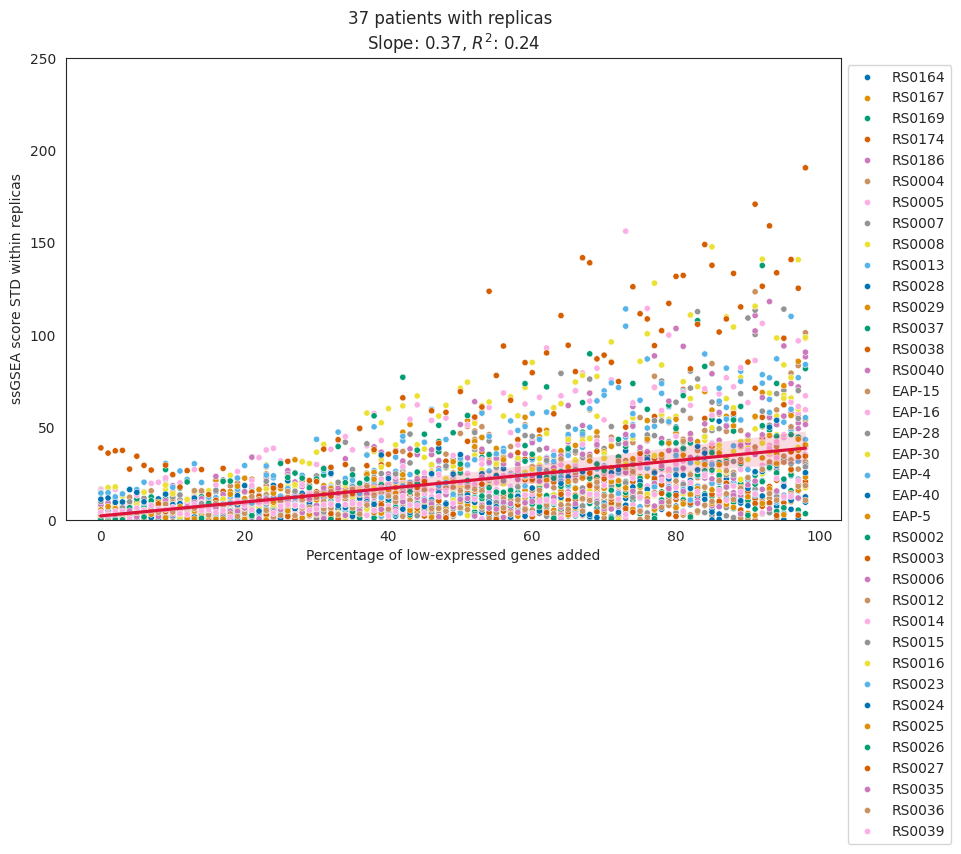

In [275]:
mask = ~annot_reprod_ldt.Group.isna()
stds = []
cases = []
percentages = []
for g in annot_reprod_ldt[mask].Case.unique():
    p = annot_reprod_ldt[annot_reprod_ldt.Case == g].index.tolist()
    for n,i in ssgsea_scores_std_low.items():
        stds.append(i[p].std())
        cases.append(g)
        percentages.append(n)

regression_data = pd.DataFrame({
    'percentage': percentages,
    'ssgsea_score_STD': stds,
    'Case': cases
})

# Линейная регрессия
X = sm.add_constant(regression_data['percentage'].astype(float))
y = regression_data['ssgsea_score_STD'].astype(float)
model = sm.OLS(y, X).fit()
slope = model.params[1]
r_squared = model.rsquared

regression_data_37_low = regression_data
regression_data_37_low.to_csv('noise_gene_data_37_low.tsv',sep='\t')
plt.figure(figsize=(10, 6))
sns.scatterplot(data=regression_data, x='percentage', y='ssgsea_score_STD', hue='Case', s=20, palette='colorblind')
sns.regplot(data=regression_data, x='percentage', y='ssgsea_score_STD', scatter=False, color='crimson',ci=95, seed=42,  units='Case')

plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0, 250)
plt.xlabel('Percentage of low-expressed genes added')
plt.ylabel('ssGSEA score STD within replicas')
plt.title(f'37 patients with replicas \nSlope: {slope:.2f}, $R^2$: {r_squared:.2f}')

plt.show()

## Cytokines vs Macrophages on technical replicates

In [41]:
USED_DATASETS_PATH = "/uftp/users/akuznetsov/data/ilya_thesis_datasets.json"
GENE_LENGTHS_PATH = "/uftp/Deconvolution/training/config/gene_length_values.tsv"
CELLS_UFTP_PATH = "/uftp/users/akuznetsov/data/Cells - Cells.tsv"
CTC_UFTP_PATH = "/uftp/users/akuznetsov/data/Annotation calculated - Cells_to_check.tsv"
BLOOD_UFTP_PATH = "/uftp/users/akuznetsov/data/Blood database - Blood.tsv"
TISSUE_UFTP_PATH = "/uftp/users/akuznetsov/data/Tissues - Tissues.tsv"
USED_ALPHA_FITTING_ANN_PATH = "/uftp/users/akuznetsov/data/alpha_fitting_ann.tsv"
USED_ALPHA_FITTING_EXP_PATH = "/uftp/users/akuznetsov/data/alpha_fitting_exp.tsv"
BLOOD_REPROD_EXP_PATH = "/uftp/COMMON_NOTEBOOKS/Deconvolution/Validation/validation_report/RR_data/expr_blood_reprod.tsv"
BLOOD_REPROD_ANN_PATH = "/uftp/COMMON_NOTEBOOKS/Deconvolution/Validation/validation_report/RR_data/annot_blood_reprod.tsv"
TISSUE_REPROD_EXP_PATH = "/uftp/COMMON_NOTEBOOKS/Deconvolution/Validation/validation_report/RR_data/expr_tissue_reprod.tsv"
TISSUE_REPROD_ANN_PATH = "/uftp/COMMON_NOTEBOOKS/Deconvolution/Validation/validation_report/RR_data/annot_tissue_reprod.tsv"
READ_COUNTS_REPROD_PATH = "/uftp/users/akuznetsov/data/read_counts_RR_ann.tsv"

In [42]:
expr_blood_reprod = pd.read_csv(BLOOD_REPROD_EXP_PATH, sep="\t", index_col=0)
expr_tissue_reprod = pd.read_csv(TISSUE_REPROD_EXP_PATH, sep="\t", index_col=0)
expr_reprod = pd.concat([expr_blood_reprod, expr_tissue_reprod], axis=0)

annot_blood_reprod = pd.read_csv(BLOOD_REPROD_ANN_PATH, sep="\t", index_col=2)
annot_tissue_reprod = pd.read_csv(TISSUE_REPROD_ANN_PATH, sep="\t", index_col=2)
annot_reprod = pd.concat(
    [annot_blood_reprod, annot_tissue_reprod], axis=0, join="inner"
)
print(annot_reprod.shape, expr_reprod.shape)

(37, 6) (37, 20062)


In [43]:
read_counts_ann = pd.read_csv(READ_COUNTS_REPROD_PATH, sep="\t", index_col=0)

### Cytokines

In [44]:
cytokine_signature = ['IL4', 'IL5', 'IL10', 'IL11', 'IL13', 'CCL8', 'TSLP', 'CCL13']

In [45]:
gene_lengths_path=Path('/uftp/gene_data_common/' 'gene_length_values.tsv')
gene_length = read_dataset(gene_lengths_path)
gene_length = gene_length/1000

In [46]:
noise_sigma = 2.05 * np.sqrt(expr_reprod.T.divide(gene_length.loc[expr_reprod.columns, 'length'], axis='index')
                                  / (read_counts_ann['Number_of_Reads_mln'])).T

In [47]:
p_c = lin_colors(expr_reprod.index)

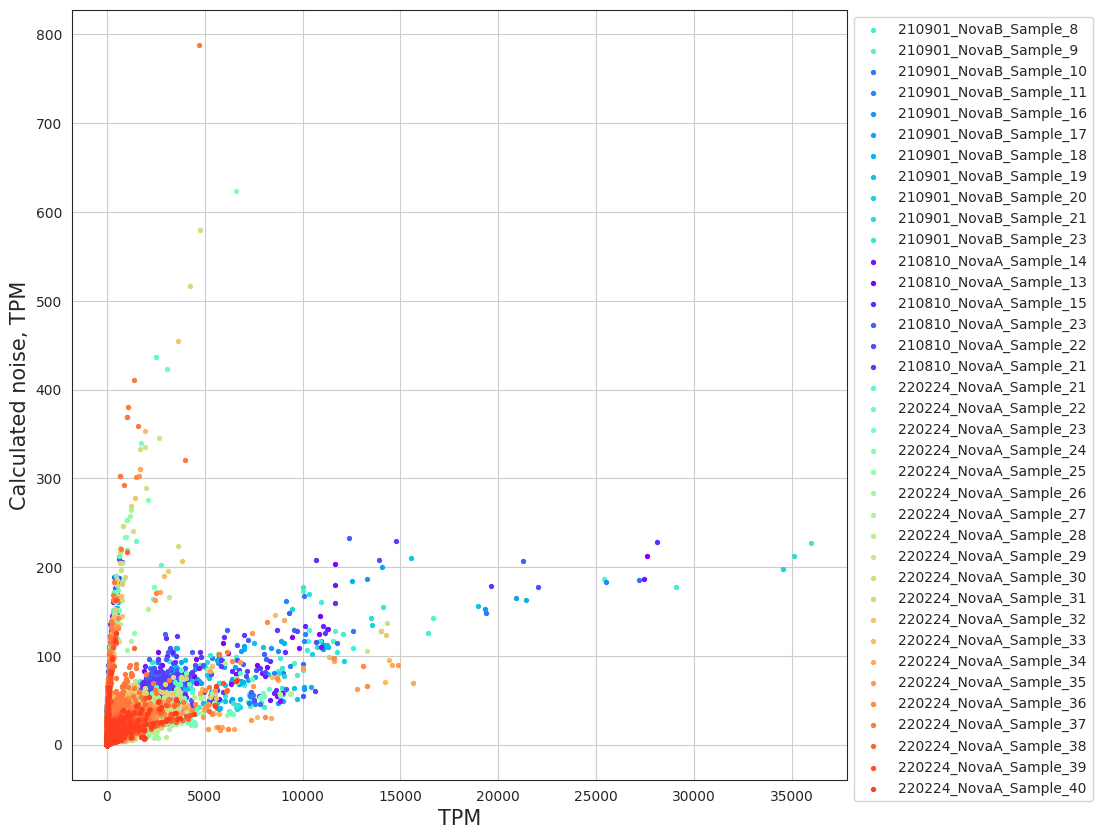

In [48]:
plt.figure(figsize = (10, 10))

for patient in expr_reprod.index.tolist():
    plt.scatter(expr_reprod.loc[patient], 3*noise_sigma.loc[patient], s=8, color=p_c[patient], label = patient)

plt.xlabel('TPM', fontsize=15)
plt.ylabel('Calculated noise, TPM', fontsize=15)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(b=None)
#plt.savefig(f"/home/eocheredko/Chess_projects/Signature_validation_paper/Figures/Calculated_noise_reprod.png")
plt.show()

In [49]:
p_c = lin_colors(annot_reprod.Group)

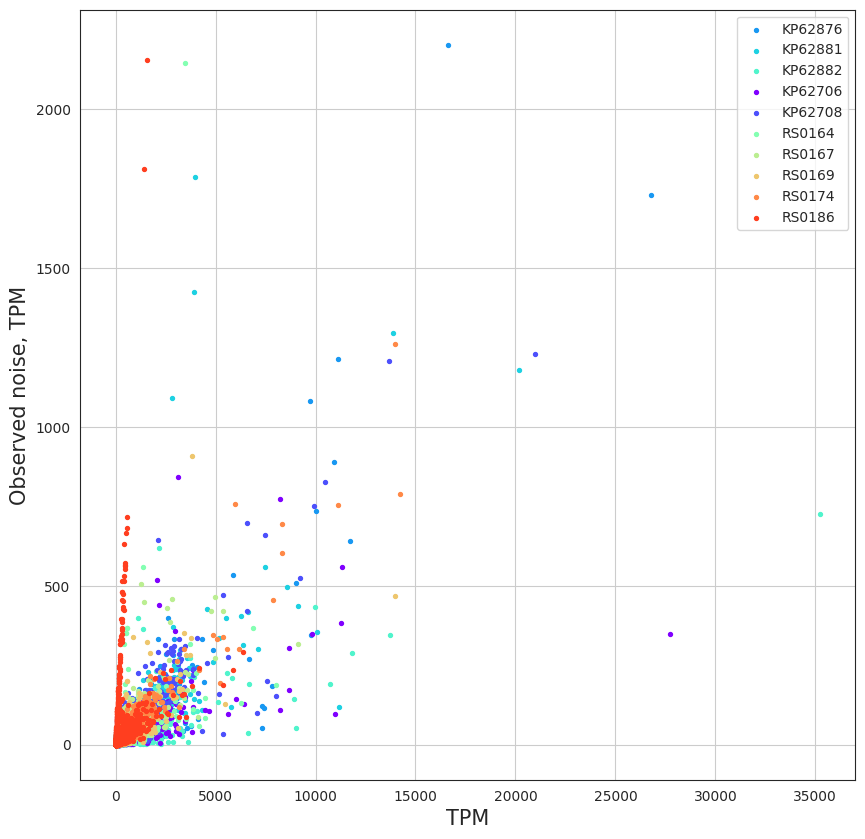

In [50]:
plt.figure(figsize = (10, 10))

for patient in annot_reprod.Group.unique():
    plt.scatter(expr_reprod.groupby(annot_reprod['Group']).mean().loc[patient], expr_reprod.groupby(annot_reprod['Group']).std().loc[patient], s=8, color=p_c[patient], label = patient)

plt.xlabel('TPM', fontsize=15)
plt.ylabel('Observed noise, TPM', fontsize=15)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid(b=None)
#plt.savefig(f"/home/eocheredko/Chess_projects/Signature_validation_paper/Figures/Observed_noise_reprod.png")
plt.show()

In [51]:
s = {'s': GeneSet('s', '', cytokine_signature)}

ssgsea_score = ssgsea_formula(expr_reprod.T, gmt_genes_alt_names(s, 
                                                              expr_reprod.columns, verbose=False))

In [52]:
sample_palette = {
    'KP62876': '#e6004d',
    'KP62881': '#f39ebd',
    'KP62882': '#a5e6e6',
    'KP62706': '#ffb39f',
    'KP62708': '#a99ad6',
    'RS0164': '#668cff',
    'RS0167': '#6fc5cf',
    'RS0169': '#f9e9c1',
    'RS0174': '#77b3ff',
    'RS0186': '#788b92'
}

Text(88.09722222222221, 0.5, 'ssgsea score')

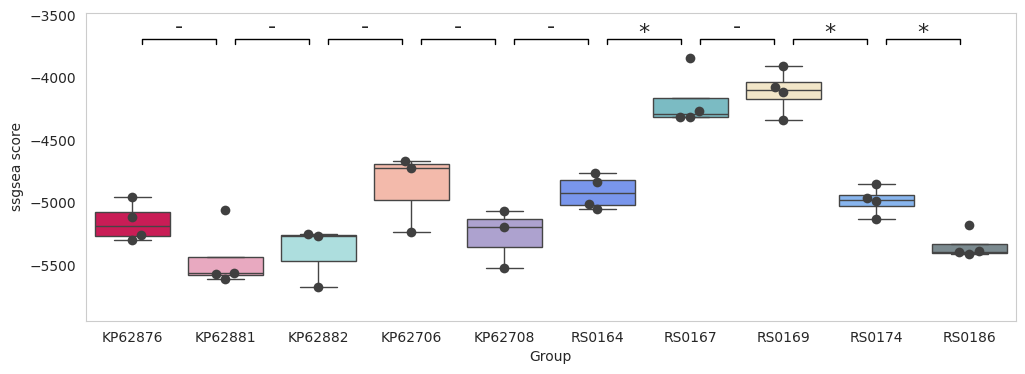

In [53]:
sns.set_style("whitegrid", {'axes.grid' : False})

ax = boxplot_with_pvalue(ssgsea_score.loc['s'], annot_reprod['Group'], 
                         order = annot_reprod.Group.unique().tolist(), 
                   palette = sample_palette)
plt.ylabel('ssgsea score')
#plt.savefig(f"/home/eocheredko/Chess_projects/Signature_validation_paper/Figures/noisy_signature_bp.svg", format="svg")

In [54]:
ssgsea_by_groups = []
for g in annot_reprod.groupby('Group'):
    ssgsea_by_groups.append(g[1].index.tolist())

In [55]:
import itertools
combinations = list(itertools.product(*ssgsea_by_groups))

In [56]:
len(combinations)

442368

In [57]:
import random

combinations = random.sample(combinations, 20000)

In [58]:
ranks = pd.DataFrame()
for c in tqdm(combinations):
    a = ssgsea_score[list(c)].loc['s']
    a.index = (annot_reprod.reindex(list(c))['Group'])
    ranks[combinations.index(c)] = a.rank()

100%|██████████| 20000/20000 [00:38<00:00, 522.31it/s]


In [59]:
import random

c = list(ranks.columns)
random.shuffle(c)

In [61]:
r_trial = ranks[c].apply(lambda x: x.sort_values().index)
r_trial.index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

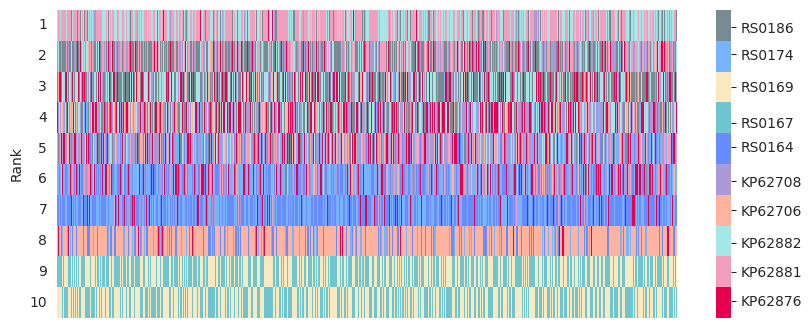

In [62]:
plt.figure(figsize = (10, 4))

myColors = ['#e6004d', '#f39ebd',
'#a5e6e6',
'#ffb39f',
'#a99ad6',
'#668cff',
'#6fc5cf',
'#f9e9c1',
'#77b3ff',
'#788b92',
]
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

ax = sns.heatmap(r_trial.replace({'KP62876':1, 'KP62881':2, 'KP62882':3, 'KP62706':4, 'KP62708':5, 'RS0164':6, 
                                  'RS0167':7, 'RS0169':8, 'RS0174':9, 'RS0186':10 
                                 }), cmap=cmap)

# Manually specify colorbar labelling after it's been generated
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([1.5 , 2.35, 3.2 , 4.15, 5 , 6, 6.7 , 7.75, 8.7 , 9.5])
colorbar.set_ticklabels(['KP62876', 'KP62881', 'KP62882', 'KP62706', 'KP62708', 'RS0164', 'RS0167', 'RS0169', 'RS0174', 'RS0186'])


# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
_, labels = plt.yticks()
plt.setp(labels, rotation=0)
plt.ylabel('Rank')
plt.xticks([])

#plt.savefig(f"/home/eocheredko/Chess_projects/Signature_validation_paper/Figures/noisy_patients_rank.png")
plt.show()

In [63]:
rank_bad = ranks.corr(method='spearman')

### Macrophages

In [64]:
pm_signature = ['MSR1', 'CSF1R', 'CD163', 'CD68', 'SIGLEC1', 'C1QA', 'C1QC', 'VSIG4']

In [65]:
s = {'s': GeneSet('s', '', pm_signature)}
ssgsea_score = ssgsea_formula(expr_reprod.T, gmt_genes_alt_names(s, 
                                                            expr_reprod.columns, verbose=False))

Text(99.59722222222221, 0.5, 'ssgsea score')

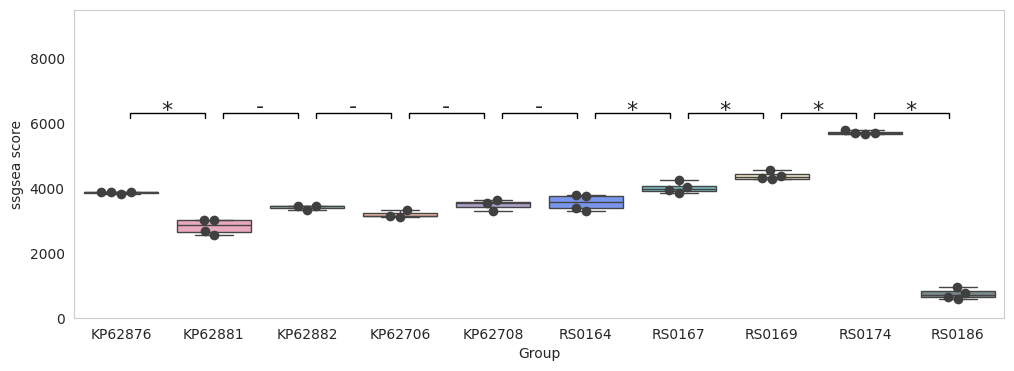

In [66]:
sns.set_style("whitegrid", {'axes.grid' : False})

boxplot_with_pvalue(ssgsea_score.loc['s'], annot_reprod['Group'], order = annot_reprod.Group.unique().tolist(), 
                   palette = sample_palette)
plt.ylim(0, 9500)
plt.ylabel('ssgsea score')
#plt.savefig(f"/home/eocheredko/Chess_projects/Signature_validation_paper/Figures/non_noisy_signature_bp.svg", format="svg")

In [67]:
ranks = pd.DataFrame()
for c in tqdm(combinations):
    a = ssgsea_score[list(c)].loc['s']
    a.index = (annot_reprod.reindex(list(c))['Group'])
    ranks[combinations.index(c)] = a.rank()

100%|██████████| 20000/20000 [00:38<00:00, 520.32it/s]


In [68]:
import random

c = list(ranks.columns)
random.shuffle(c)

In [69]:
r_trial = ranks[c].apply(lambda x: x.sort_values().index)
r_trial.index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

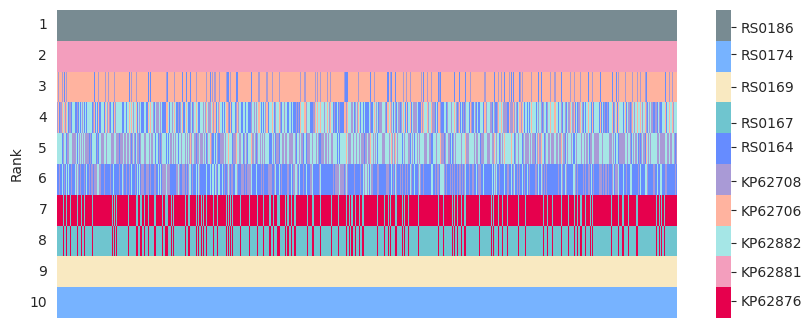

In [70]:
plt.figure(figsize = (10, 4))

myColors = ['#e6004d', '#f39ebd',
'#a5e6e6',
'#ffb39f',
'#a99ad6',
'#668cff',
'#6fc5cf',
'#f9e9c1',
'#77b3ff',
'#788b92',
]
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

ax = sns.heatmap(r_trial.replace({'KP62876':1, 'KP62881':2, 'KP62882':3, 'KP62706':4, 'KP62708':5, 'RS0164':6, 
                                  'RS0167':7, 'RS0169':8, 'RS0174':9, 'RS0186':10 
                                 }), cmap=cmap)

# Manually specify colorbar labelling after it's been generated
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([1.5 , 2.35, 3.2 , 4.15, 5 , 6, 6.7 , 7.75, 8.7 , 9.5])
colorbar.set_ticklabels(['KP62876', 'KP62881', 'KP62882', 'KP62706', 'KP62708', 'RS0164', 'RS0167', 'RS0169', 'RS0174', 'RS0186'])


# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
_, labels = plt.yticks()
plt.setp(labels, rotation=0)
plt.ylabel('Rank')
plt.xticks([])

#plt.savefig(f"/home/eocheredko/Chess_projects/Signature_validation_paper/Figures/non_noisy_patients_rank.png")
plt.show()

In [72]:
ranks_good = ranks.corr(method='spearman')

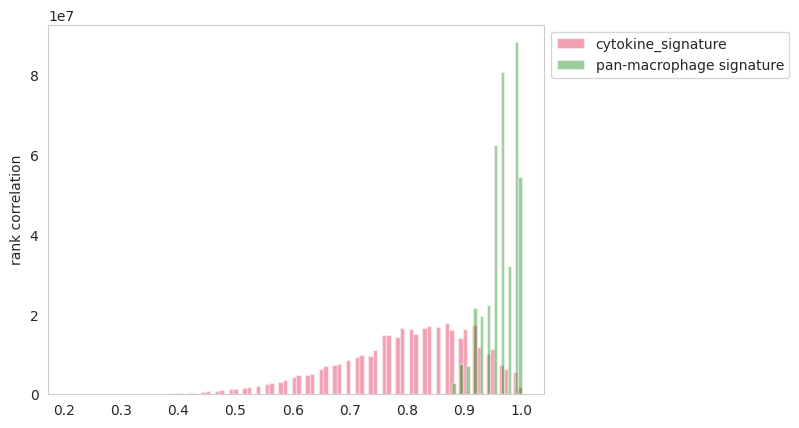

In [73]:
plt.subplots()
sns.distplot(rank_bad, kde=False, bins = 100, color = 'crimson', label = 'cytokine_signature')
sns.distplot(ranks_good, kde=False, bins = 20, color = 'g', label = 'pan-macrophage signature')
plt.legend(bbox_to_anchor = (1, 1))
plt.ylabel('rank correlation')
#plt.savefig(f"/home/eocheredko/Chess_projects/Signature_validation_paper/Figures/noisy_vs_nonoisy_ranks.svg", format="svg")
plt.show()